Dataset shape: (569, 30)
Class distribution:
 1    357
0    212
Name: count, dtype: int64

--- LogisticRegression ---
Accuracy: 0.9825  Precision: 0.9861  Recall: 0.9861  F1: 0.9861  ROC AUC: 0.9957

Classification report:
               precision    recall  f1-score   support

           0     0.9762    0.9762    0.9762        42
           1     0.9861    0.9861    0.9861        72

    accuracy                         0.9825       114
   macro avg     0.9812    0.9812    0.9812       114
weighted avg     0.9825    0.9825    0.9825       114

5-fold CV ROC AUC on train: mean=0.9938 std=0.0101

--- SVM (RBF) ---
Accuracy: 0.9825  Precision: 0.9861  Recall: 0.9861  F1: 0.9861  ROC AUC: 0.9950

Classification report:
               precision    recall  f1-score   support

           0     0.9762    0.9762    0.9762        42
           1     0.9861    0.9861    0.9861        72

    accuracy                         0.9825       114
   macro avg     0.9812    0.9812    0.9812       114
w

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9561  Precision: 0.9467  Recall: 0.9861  F1: 0.9660  ROC AUC: 0.9901

Classification report:
               precision    recall  f1-score   support

           0     0.9744    0.9048    0.9383        42
           1     0.9467    0.9861    0.9660        72

    accuracy                         0.9561       114
   macro avg     0.9605    0.9454    0.9521       114
weighted avg     0.9569    0.9561    0.9558       114



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:39:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:39:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:39:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:39:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:39:49] WARNING: /w

5-fold CV ROC AUC on train: mean=0.9902 std=0.0161


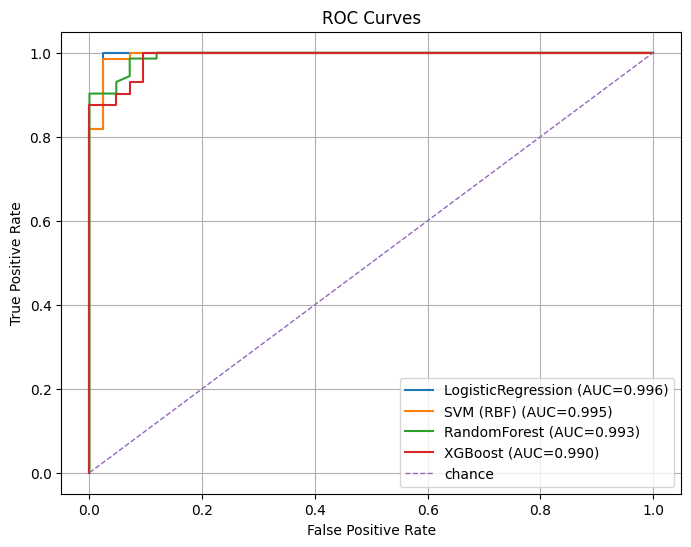


Top features for RandomForest top features


,0
worst perimeter,0.133100
worst area,0.128052
worst concave points,0.108107
mean concave points,0.094414
worst radius,0.090639
mean radius,0.058662
mean perimeter,0.055242
mean area,0.049938
mean concavity,0.046207
worst concavity,0.035357


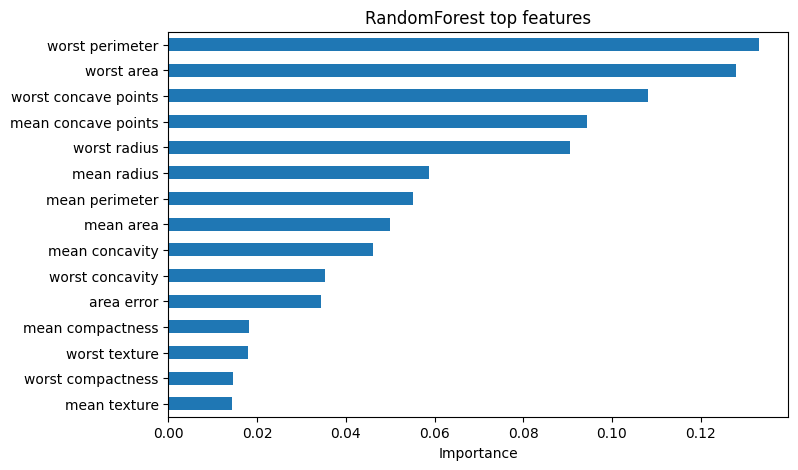


Top features for XGBoost top features


,0
worst radius,0.585115
worst perimeter,0.165952
worst concave points,0.052235
mean concave points,0.035588
texture error,0.031616
worst compactness,0.018118
worst area,0.017973
worst texture,0.014540
radius error,0.011736
perimeter error,0.010272


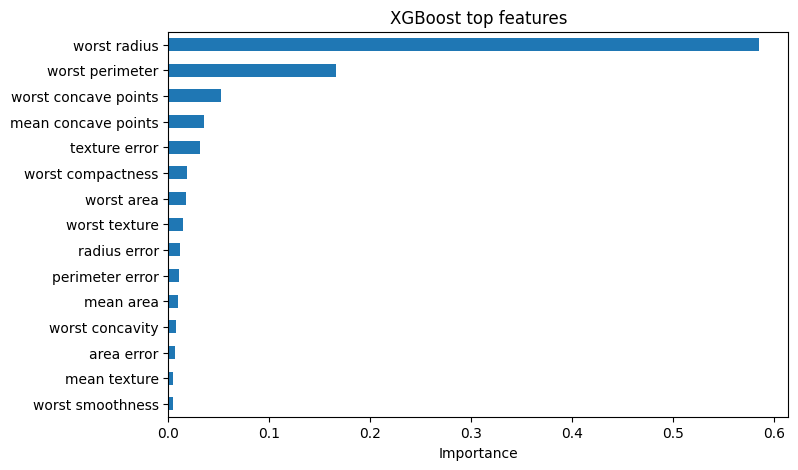


RandomizedSearch best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 4, 'clf__max_depth': 6}
Best RF ROC AUC on test: 0.9943783068783069


In [1]:
# Breast cancer classification - complete pipeline
# Requirements: scikit-learn, xgboost, matplotlib, pandas, seaborn (optional)
# Install: pip install scikit-learn xgboost matplotlib pandas seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, classification_report,
                             ConfusionMatrixDisplay)
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
    xgboost_available = True
except Exception:
    xgboost_available = False

# 1. Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)  # 0 = malignant, 1 = benign (sklearn mapping)

print("Dataset shape:", X.shape)
print("Class distribution:\n", y.value_counts())

# 2. Train/test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Preprocessing + model pipelines
scaler = StandardScaler()

models = {
    "LogisticRegression": Pipeline([("scaler", scaler),
                                    ("clf", LogisticRegression(max_iter=10000, solver="liblinear"))]),
    "SVM (RBF)": Pipeline([("scaler", scaler),
                           ("clf", SVC(probability=True))]),
    "RandomForest": Pipeline([("scaler", scaler),  # scaler harmless for tree-based
                              ("clf", RandomForestClassifier(n_estimators=200, random_state=42))]),
}

if xgboost_available:
    models["XGBoost"] = Pipeline([("scaler", scaler),
                                  ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))])

# 4. Train, evaluate function
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test, cv=5):
    print(f"\n--- {name} ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    print("Accuracy: {:.4f}  Precision: {:.4f}  Recall: {:.4f}  F1: {:.4f}  ROC AUC: {:.4f}"
          .format(acc, prec, rec, f1, roc))
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

    # Cross-validated accuracy on train set (for stability check)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc")
    print(f"{cv}-fold CV ROC AUC on train: mean={cv_scores.mean():.4f} std={cv_scores.std():.4f}")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    return {"name": name, "model": pipeline, "y_pred": y_pred, "y_proba": y_proba,
            "metrics": {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "roc": roc},
            "roc": (fpr, tpr)}

# 5. Run evaluations
results = []
for name, pipe in models.items():
    results.append(evaluate_model(name, pipe, X_train, y_train, X_test, y_test))

# 6. Plot ROC curves
plt.figure(figsize=(8,6))
for res in results:
    fpr, tpr = res["roc"]
    plt.plot(fpr, tpr, label=f"{res['name']} (AUC={res['metrics']['roc']:.3f})")
plt.plot([0,1],[0,1], linestyle="--", linewidth=1, label="chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

# 7. Feature importance for tree models (RandomForest, XGBoost)
def show_feature_importances(pipeline, title="Feature importances"):
    clf = pipeline.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        fi = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(15)
        print("\nTop features for", title)
        display(fi)
        plt.figure(figsize=(8,5))
        fi.sort_values().plot(kind="barh")
        plt.title(title)
        plt.xlabel("Importance")
        plt.show()
    else:
        print(f"No feature_importances_ for {title}")

# Show for RandomForest and XGBoost (if available)
if "RandomForest" in models:
    show_feature_importances(models["RandomForest"], title="RandomForest top features")
if xgboost_available and "XGBoost" in models:
    show_feature_importances(models["XGBoost"], title="XGBoost top features")

# 8. Example: Hyperparameter tuning (small grid for RandomForest)
from sklearn.model_selection import RandomizedSearchCV
rf_pipeline = models["RandomForest"]
param_dist = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth": [None, 6, 10, 20],
    "clf__min_samples_split": [2, 4, 8]
}
search = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist, n_iter=6, cv=4, scoring="roc_auc", random_state=42)
search.fit(X_train, y_train)
print("\nRandomizedSearch best params:", search.best_params_)
best_rf = search.best_estimator_
y_proba_best = best_rf.predict_proba(X_test)[:,1]
print("Best RF ROC AUC on test:", roc_auc_score(y_test, y_proba_best))

# End
